In [1]:
import sympy as sp
import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import autoscattering.architecture_optimizer as arch_opt
import autoscattering.constraints as msc
import autoscattering.symbolic as sym
np.set_printoptions(linewidth=200)

class MinimalAddedInputNoise(msc.Base_Constraint):
    def __call__(self, scattering_matrix, coupling_matrix, kappa_int_matrix):
        '''
        calculates the difference between the number of added input photons and the quantum limit

        input arguments:
        scattering matrix: full scattering matrix for the current parameter set, this also includes the scattering from and to the auxiliary modes
        coupling matrix: dimensionless coupling matrix (sigma_z @ H in our equations) for the current parameter set, this constraint does not make any use of the coupling matrix
        kappa_int_matrix: diagonal matrix with the dimensionless intrinsic loss rates on the diagonal
        '''

        # calculate the linear response to fluctuations entering from the intrinsic loss channels (\mathcal{N} in the equations above)
        noise_matrix = (scattering_matrix - jnp.eye(scattering_matrix.shape[0])) @ jnp.complex_(jnp.sqrt(kappa_int_matrix))

        # calculate number of added photons at the input port, already considers that the target scattering matrix will be enforced
        total_noise = 1/2 * (jnp.sum(jnp.abs(scattering_matrix[0,2:])**2) + jnp.sum(jnp.abs(noise_matrix[0,:])**2))
        quantum_limit = 1/2
        return total_noise-quantum_limit

class MinimalAddedOutputNoise(msc.Base_Constraint):
    def __init__(self, Gval, input_output_corotating):
        '''
        Gval: target gain value
        input_output_corotating: True if input and output are corotating, False if they are counterrotating. In later case the minimum number of added photons is larger one photon.
        '''
        self.Gval = Gval
        self.input_output_corotating = input_output_corotating

    def __call__(self, scattering_matrix, coupling_matrix, kappa_int_matrix):
        '''
        calculates the difference between the number of added output photons and the quantum limit

        input arguments:
        scattering matrix: full scattering matrix for the current parameter set, this also includes the scattering from and to the auxiliary modes
        coupling matrix: dimensionless coupling matrix (sigma_z @ H in our equations) for the current parameter set, this constraint does not make any use of the coupling matrix
        kappa_int_matrix: diagonal matrix with the dimensionless intrinsic loss rates on the diagonal
        '''

        # calculate the linear response to fluctuations entering from the intrinsic loss channels (\mathcal{N} in the equations above)
        noise_matrix = (scattering_matrix - jnp.eye(scattering_matrix.shape[0])) @ jnp.complex_(jnp.sqrt(kappa_int_matrix))

        # calculate number of added photons at the output port, already considers that the target scattering matrix will be enforced
        total_noise = 1/2 * (jnp.sum(jnp.abs(scattering_matrix[1,2:])**2) + jnp.sum(jnp.abs(noise_matrix[1,:])**2))

        if self.input_output_corotating:
            quantum_limit = (self.Gval - 1)/2
        else:
            quantum_limit = (self.Gval + 1)/2

        return total_noise-quantum_limit


In [51]:
Gval = 3. # target gain value
mode_types = [True, False, True] # defines whether modes are co- or counterrotating 
S_target = sp.Matrix([[0,0],[np.sqrt(Gval),0]])
enforced_constraints = [MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval, input_output_corotating=mode_types[0]==mode_types[1])]

optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=1,
    mode_types=mode_types,
    port_intrinsic_losses=True, # allows an additional intrinsic loss channel for input and output port
    enforced_constraints=enforced_constraints, # enforces quantum limited noise for input and output port, default is an empty list
    kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
    solver_options={'maxiter': 2000},
    make_initial_test=True
)

fully connected graph is a valid graph


In [52]:
list_of_irreducible_graphs = optimizer.perform_depth_first_search()

prepare list of all possible graphs


96it [00:00, 238821.58it/s]


96 graphs identified
start depth-first search
test all graphs with 9 degrees of freedom:


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


test all graphs with 8 degrees of freedom:


100%|██████████| 4/4 [00:00<00:00, 46.50it/s]


test all graphs with 7 degrees of freedom:


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 1 elements


In [53]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout  # Use this for hierarchical layout
import autoscattering.architecture as arch
import copy

In [54]:


def identify_direct_subgraphs(graph, allowed_entries):
    all_subgraphs = []
    for idx, element in enumerate(graph):
        allowed_entries_element = allowed_entries[idx]
        if element != np.min(allowed_entries_element):
            new_entry = allowed_entries_element[np.where(allowed_entries_element == element)[0][0] - 1]
            new_graph = graph.copy()
            new_graph[idx] = new_entry
            all_subgraphs.append(new_graph)
    return all_subgraphs

def find_graph_idx(graph, all_graphs):
    for count, test_graph in enumerate(all_graphs):
        if np.all(graph==test_graph):
            return count
    return None

In [55]:
from tqdm import tqdm

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [00:00<00:00, 982.30it/s]


starting position evaluation
starting drawing


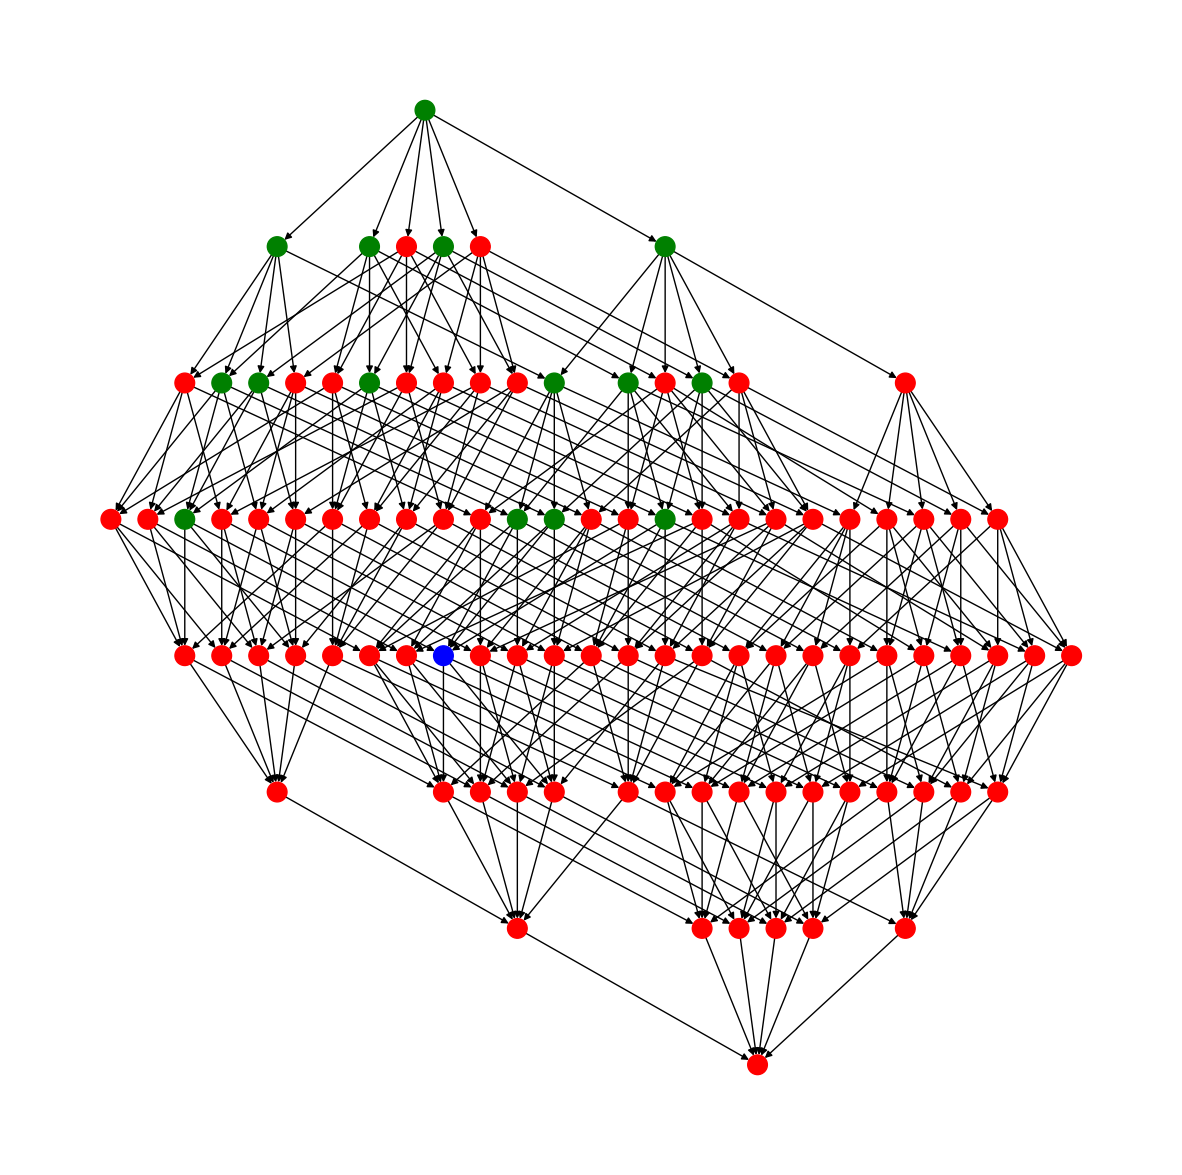

In [56]:
sort_idxs = np.flip(np.argsort(optimizer.complexity_levels))
all_graphs = optimizer.list_of_upper_triangular_coupling_matrices[sort_idxs]
num_graphs = len(all_graphs)
allowed_entries = optimizer.possible_matrix_entries

fig, ax = plt.subplots(figsize=(15,15))

G = nx.DiGraph()
G.add_nodes_from([idx for idx in range(num_graphs)])

node_labels = {}
# for idx in range(num_graphs):
#     node_labels[idx] = str(idx)

node_colors = []
for idx in tqdm(range(num_graphs)):
    selected_graph = all_graphs[idx]
    # check if graph is valid or not
    if find_graph_idx(selected_graph, list_of_irreducible_graphs) is not None:
        color = 'blue'
    elif arch.check_if_subgraph_upper_triangle(selected_graph, list_of_irreducible_graphs):
        color = 'green'
    else:
        color = 'red'
    node_colors.append(color)

    subgraphs = identify_direct_subgraphs(selected_graph, allowed_entries)
    for subgraph in subgraphs:
        idx_subgraph = find_graph_idx(subgraph, all_graphs)
        # if idx_subgraph is not None:
        G.add_edge(idx, idx_subgraph)

print('starting position evaluation')
pos = graphviz_layout(G, prog="dot")  # 'dot' is used for hierarchical (top-down) layout
print('starting drawing')
nx.draw(
    G,
    pos,
    ax=ax,
    node_color=node_colors,
    node_size=200
    # labels=node_labels
)

In [49]:
S_target = sp.Matrix([[0,0],[1,0]])
print('target scattering matrix of an isolator:')
sym.render(S_target)
optimizer = arch_opt.Architecture_Optimizer(
    S_target=sp.Matrix([[0,0],[1,0]]),
    num_auxiliary_modes=1,
)
list_of_irreducible_graphs = optimizer.perform_depth_first_search()

target scattering matrix of an isolator:


<IPython.core.display.Math object>

fully connected graph is a valid graph
prepare list of all possible graphs


216it [00:00, 468685.81it/s]


216 graphs identified
start depth-first search
test all graphs with 9 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00, 35.34it/s]


test all graphs with 8 degrees of freedom:


100%|██████████| 6/6 [00:00<00:00, 81.09it/s]


test all graphs with 7 degrees of freedom:


100%|██████████| 15/15 [00:00<00:00, 33.27it/s]


test all graphs with 6 degrees of freedom:


100%|██████████| 10/10 [00:00<00:00, 49.53it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 3 elements


100%|██████████| 216/216 [00:00<00:00, 482.96it/s]


starting position evaluation
starting drawing


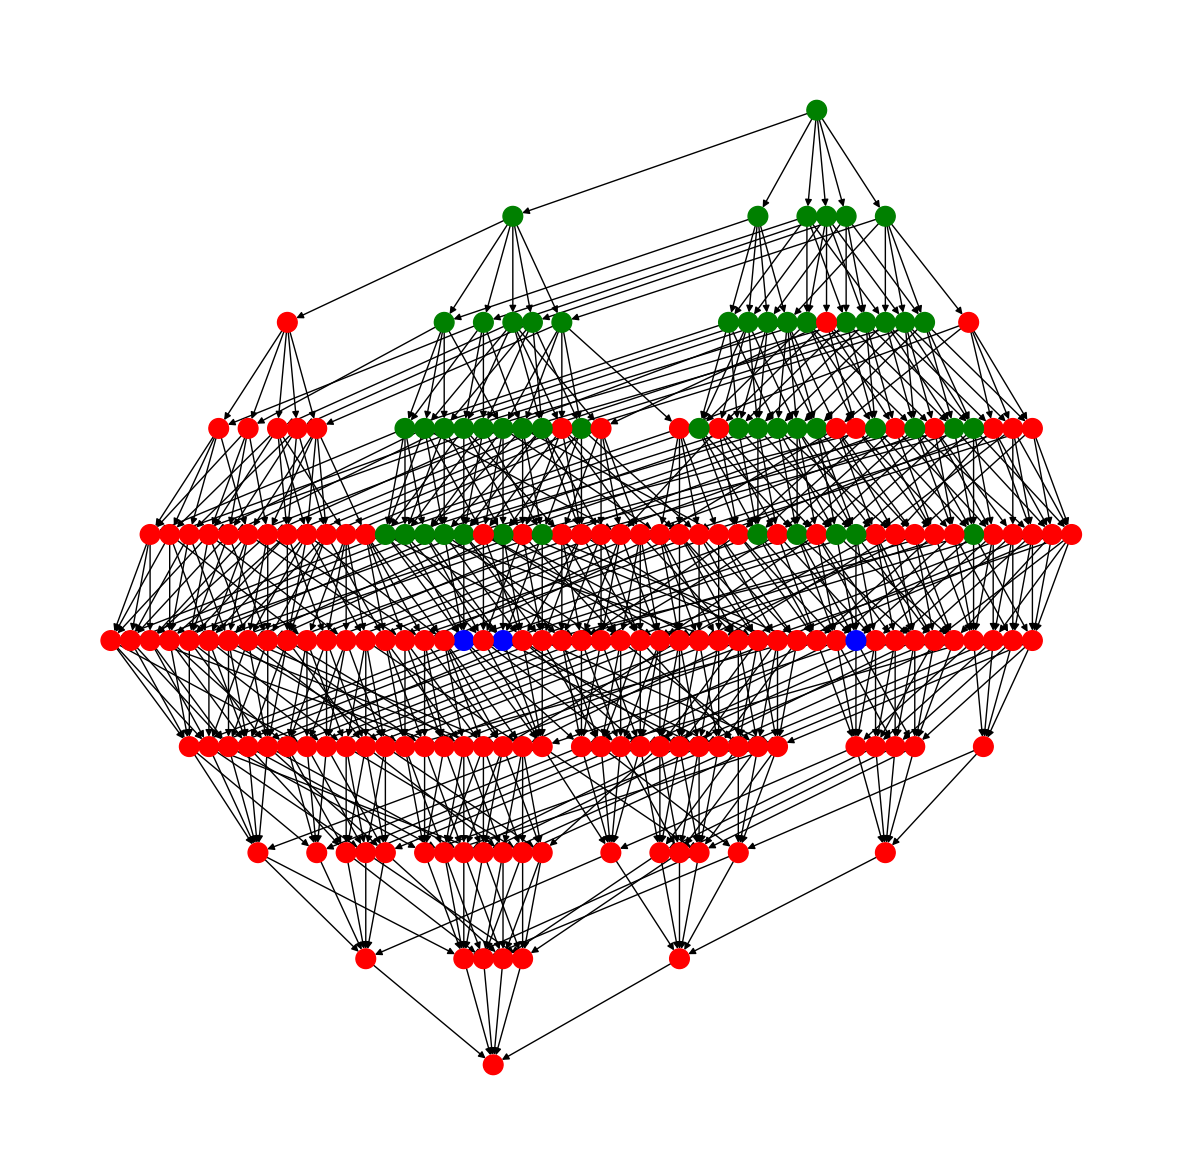

In [50]:
sort_idxs = np.flip(np.argsort(optimizer.complexity_levels))
all_graphs = optimizer.list_of_upper_triangular_coupling_matrices[sort_idxs]
num_graphs = len(all_graphs)
allowed_entries = optimizer.possible_matrix_entries

fig, ax = plt.subplots(figsize=(15,15))

G = nx.DiGraph()
G.add_nodes_from([idx for idx in range(num_graphs)])

node_labels = {}
# for idx in range(num_graphs):
#     node_labels[idx] = str(idx)

node_colors = []
for idx in tqdm(range(num_graphs)):
    selected_graph = all_graphs[idx]
    # check if graph is valid or not
    if find_graph_idx(selected_graph, list_of_irreducible_graphs) is not None:
        color = 'blue'
    elif arch.check_if_subgraph_upper_triangle(selected_graph, list_of_irreducible_graphs):
        color = 'green'
    else:
        color = 'red'
    node_colors.append(color)

    subgraphs = identify_direct_subgraphs(selected_graph, allowed_entries)
    for subgraph in subgraphs:
        idx_subgraph = find_graph_idx(subgraph, all_graphs)
        # if idx_subgraph is not None:
        G.add_edge(idx, idx_subgraph)

print('starting position evaluation')
pos = graphviz_layout(G, prog="dot")  # 'dot' is used for hierarchical (top-down) layout
print('starting drawing')
nx.draw(
    G,
    pos,
    ax=ax,
    node_color=node_colors,
    node_size=200
    # labels=node_labels
)

In [57]:
Gval = 3. # target gain value
mode_types = [True, False, False, True] # defines whether modes are co- or counterrotating 
S_target = sp.Matrix([[0,0],[np.sqrt(Gval),0]])
enforced_constraints = [MinimalAddedInputNoise(), MinimalAddedOutputNoise(Gval=Gval, input_output_corotating=mode_types[0]==mode_types[1])]

optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=2,
    mode_types=mode_types,
    port_intrinsic_losses=False, # no intrinsic losses on the port modes, this is also the default option
    enforced_constraints=enforced_constraints, # enforces quantum limited noise for input and output port, default is an empty list
    kwargs_optimization={'num_tests': 30}, # to reduce the risk of false negative classifications, we increase the number of tries till a graph is labeled is invalid
    solver_options={'maxiter': 2000}
)

fully connected graph is a valid graph


In [58]:
list_of_irreducible_graphs = optimizer.perform_depth_first_search()

prepare list of all possible graphs


2304it [00:00, 270577.53it/s]


2304 graphs identified
start depth-first search
test all graphs with 16 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


test all graphs with 15 degrees of freedom:


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]


test all graphs with 14 degrees of freedom:


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


test all graphs with 13 degrees of freedom:


100%|██████████| 49/49 [00:03<00:00, 15.55it/s]


test all graphs with 12 degrees of freedom:


100%|██████████| 92/92 [00:34<00:00,  2.64it/s]


test all graphs with 11 degrees of freedom:


100%|██████████| 94/94 [00:03<00:00, 29.37it/s]


test all graphs with 10 degrees of freedom:


100%|██████████| 54/54 [00:01<00:00, 47.51it/s]


test all graphs with 9 degrees of freedom:


100%|██████████| 15/15 [00:00<00:00, 81.64it/s]


test all graphs with 8 degrees of freedom:


100%|██████████| 5/5 [00:00<00:00, 121.67it/s]


test all graphs with 7 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 3 elements


100%|██████████| 2304/2304 [01:01<00:00, 37.18it/s]


starting position evaluation
starting drawing


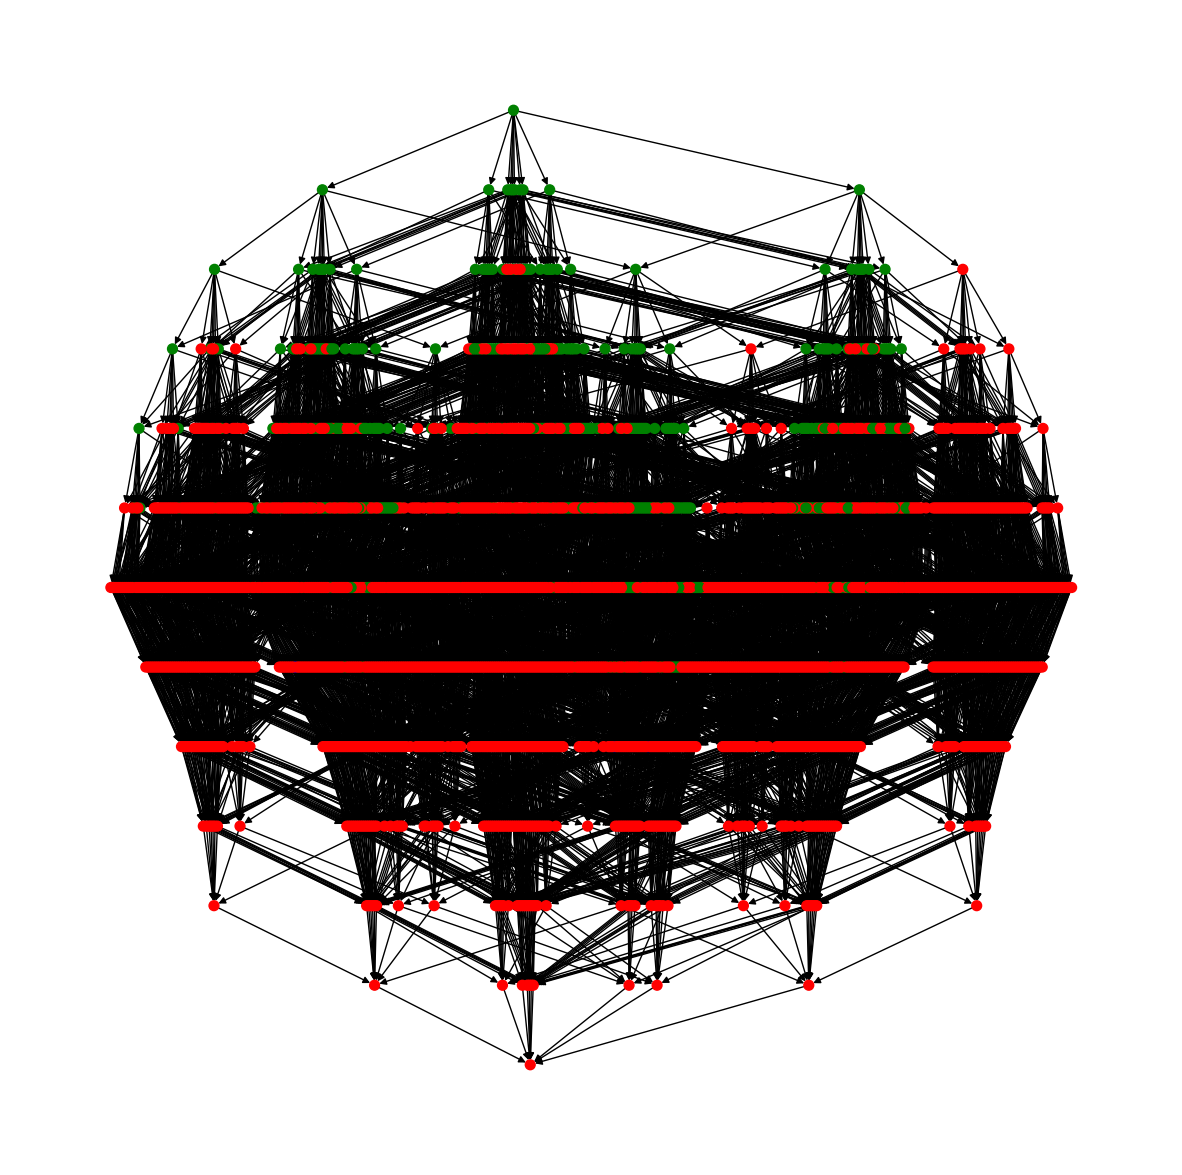

In [60]:
sort_idxs = np.flip(np.argsort(optimizer.complexity_levels))
all_graphs = optimizer.list_of_upper_triangular_coupling_matrices[sort_idxs]
num_graphs = len(all_graphs)
allowed_entries = optimizer.possible_matrix_entries

fig, ax = plt.subplots(figsize=(15,15))

G = nx.DiGraph()
G.add_nodes_from([idx for idx in range(num_graphs)])

node_labels = {}
# for idx in range(num_graphs):
#     node_labels[idx] = str(idx)

node_colors = []
for idx in tqdm(range(num_graphs)):
    selected_graph = all_graphs[idx]
    # check if graph is valid or not
    if find_graph_idx(selected_graph, list_of_irreducible_graphs) is not None:
        color = 'blue'
    elif arch.check_if_subgraph_upper_triangle(selected_graph, list_of_irreducible_graphs):
        color = 'green'
    else:
        color = 'red'
    node_colors.append(color)

    subgraphs = identify_direct_subgraphs(selected_graph, allowed_entries)
    for subgraph in subgraphs:
        idx_subgraph = find_graph_idx(subgraph, all_graphs)
        # if idx_subgraph is not None:
        G.add_edge(idx, idx_subgraph)

print('starting position evaluation')
pos = graphviz_layout(G, prog="dot")  # 'dot' is used for hierarchical (top-down) layout
print('starting drawing')
nx.draw(
    G,
    pos,
    ax=ax,
    node_color=node_colors,
    node_size=50
    # labels=node_labels
)

In [ ]:
# import matplotlib.pyplot as plt
# import networkx as nx
# import pydot
# from networkx.drawing.nx_pydot import graphviz_layout

# fig = plt.figure(figsize=(20,20))
# T = nx.balanced_tree(5, 5)
# pos = graphviz_layout(T, prog="dot")
# nx.draw(T, pos)
# plt.show()


This is a DAG.


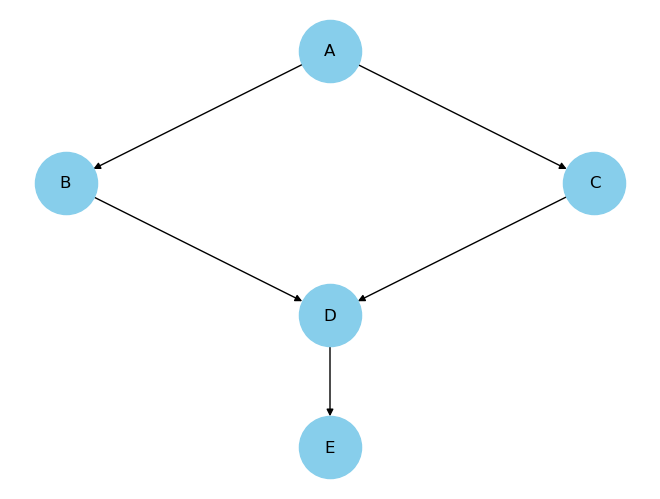

In [130]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout  # Use this for hierarchical layout

# Create a directed acyclic graph (DAG)
G = nx.DiGraph()

# Add edges (a -> b)
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
G.add_edges_from(edges)

# Check if the graph is acyclic
if nx.is_directed_acyclic_graph(G):
    print("This is a DAG.")

# Use graphviz_layout for top-to-bottom layout (requires pygraphviz)
pos = graphviz_layout(G, prog="dot")  # 'dot' is used for hierarchical (top-down) layout

# Draw the DAG
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", arrows=True)
plt.show()

In [13]:
1+5+25+125+625+625*5

3906